In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import sys
sys.path.insert(0,'./gdrive/My Drive/descript-research-test/')
from utils import *
from utils.other_utils import *
from models.synthesis import Synthesis
import random
import math
import pdb
import copy
from models import dummy

In [0]:
Path.ls = lambda x : list(x.iterdir())

In [0]:
%load_ext autoreload
%autoreload 2

In [0]:
project_path = Path('./gdrive/My Drive/descript-research-test')
data_path = project_path/'data'

In [0]:
strokes = np.load(data_path/'strokes-py3.npy', allow_pickle=True)
with open(data_path/'sentences.txt') as f:
    texts = f.readlines()

In [7]:
process_text = ProcessText()
# tokenize
char_list = process_text.tokenize(texts)
char_list[3][:10]

['<start>', 'p', 'r', 'e', 'v', 'i', 'o', 'u', 's', ' ']

In [8]:
# create vocab
word2idx,idx2word = process_text.create_vocab()
len(word2idx)

80

In [9]:
# numericalize
char_data = process_text.numericalize()
char_data[3][:10]

[26, 69, 71, 58, 75, 62, 68, 74, 72, 1]

In [10]:
# sanity check
len(char_data[0]),len(char_list[0])

(28, 28)

In [0]:
process_strokes = ProcessStrokes()
norm_strokes = process_strokes.normalize(copy.deepcopy(strokes))
final_strokes =  process_strokes.add_tokens(copy.deepcopy(norm_strokes))

In [12]:
cutoff = round(0.1*len(final_strokes))
cutoff

600

In [0]:
train_data = char_data[cutoff:],final_strokes[cutoff:]
valid_data = char_data[:cutoff],final_strokes[:cutoff]

In [0]:
train_dataset = CustomDataset(*train_data)
valid_dataset = CustomDataset(*valid_data)

In [15]:
len(train_dataset), len(valid_dataset)

(5400, 600)

In [0]:
train_loader = DataLoader(train_dataset,batch_size=256,shuffle=True,collate_fn=custom_collate)
valid_loader = DataLoader(valid_dataset,batch_size=300,collate_fn=custom_collate)

In [17]:
# If GPU available
if torch.cuda.is_available():
    print("Using the GPU")
    device = torch.device("cuda")
else:
    print("Using CPU")
    device = torch.device("cpu")

Using the GPU


In [0]:
def repackage_hidden(new_state):
    if isinstance(new_state,torch.Tensor): 
        return new_state.detach()
    else: 
        return tuple(repackage_hidden(h) for h in new_state)

In [0]:
bptt = 400
def train_epoch(model, train_loader,opt,len_train,clip_norm):
    model.train()
    train_metric.reset_state()
    new_state = None
    for x,y in tqdm(train_loader,total=len_train):
        x,y = x.to(device), y.to(device)
        state,kappa = None, 0
        context = torch.zeros((x.size(0),1,enc_sz),dtype=torch.float32).to(device)

        for i in range(math.ceil(y.size(1)/bptt)):
            y_inp = y[:,i*bptt:(i+1)*bptt]     
            y_op = y[:,i*bptt+1:(i+1)*bptt+1] # remove first token
            if y_inp.size() != y_op.size(): # last bptt element
                pad = torch.as_tensor([4,0.,0.]).view(1,1,-1).expand(y_inp.size(0),1,3).to(device)
                y_op = torch.cat([y_op,pad],1)

            params, state, context, kappa = model(x,y_inp,state,context,kappa)
            state, context, kappa = repackage_hidden((state, context, kappa))
            loss = mask_loss_func(params,y_op)
            train_metric.update_state(params,y_op)
            model.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(),clip_norm)
            opt.step()

In [0]:
train_metric = LossMetric(mask_end=False)
valid_metric = LossMetric(mask_end=False)
loss_ce = nn.CrossEntropyLoss(reduction='none')

In [0]:
def mask_loss_func(preds, y_true):
    intrp,coords = y_true[:,:,0].long(), y_true[:,:,1:]
    mask = (~(intrp==4)).float()
    ce_preds,pi = preds[:2]
    ce_preds = ce_preds.transpose(-1,1)
    ce = loss_ce(ce_preds, intrp)
    ce = mask*ce

    probs = pi*calc_prob(coords,* preds[2:]) 
    probs = torch.sum(probs,-1)
    nll = -mask*(torch.log(probs+ 1e-10))
    if torch.isnan(nll.sum()):
        pdb.set_trace()
    return (ce.sum()+ nll.sum()) /mask.sum()

In [0]:
def valid_epoch(model, valid_loader,len_val):
    model.eval()
    valid_metric.reset_state()
    with torch.no_grad():
        for x,y in valid_loader:
            state,kappa = None, 0
            context = torch.zeros((x.size(0),1,enc_sz),dtype=torch.float32).to(device)
            x,y = x.to(device), y.to(device)
            params = model(x, y[:,:-1], state, context, kappa)[0]
            valid_metric.update_state(params,y[:,1:])

In [0]:
def fit(model,epochs,max_lr,clip=0.4,wd=0):

    opt = torch.optim.AdamW(model.parameters(), lr = max_lr, weight_decay=wd,betas= [0.95,0.999])
    lr = list(np.linspace(1e-6,max_lr,epochs//2)) + list(np.linspace(max_lr,1e-6,math.ceil(epochs/2)))
    mom = list(np.linspace(0.95,0.85,epochs//2)) + list(np.linspace(0.85,0.95,math.ceil(epochs/2)))
    train_logs = {'ce_tl':[],'nll_tl':[],'tot_tl':[],'ce_vl':[],'nll_vl':[],'tot_vl':[],}
    best_valid_loss = float('inf')
    len_train,len_val = len(train_loader), len(valid_loader)
    for e in tqdm(range(epochs)):
        opt.defaults['lr'] = lr[e]
        opt.defaults['betas'][0] = mom[e]
        train_epoch(model,train_loader,opt,len_train,clip)
        valid_epoch(model, valid_loader, len_val)
        ce_tl,nll_tl,tot_tl = train_metric.result()
        ce_vl, nll_vl, tot_vl = valid_metric.result()
        
        if e%3 == 0 or e == epochs-1:
            tqdm.write(f'\nEpoch:{e}  Train Loss: {tot_tl:.4f}  Valid Loss: {tot_vl:.4f}    Best Valid:{best_valid_loss:.3f}') 
                    
        if  tot_vl < best_valid_loss:
            best_valid_loss = tot_vl
            best_model = copy.deepcopy(model)
        
        train_logs['tot_tl'].append(tot_tl)
        train_logs['ce_tl'].append(ce_tl)
        train_logs['nll_tl'].append(nll_tl)
        train_logs['tot_vl'].append(tot_vl)
        train_logs['ce_vl'].append(ce_vl)
        train_logs['nll_vl'].append(nll_vl)

    return best_model.to(device), train_logs

In [0]:
enc_sz = 70
model = Synthesis(enc_sz,dec_sz = 30,att_hd = 20,n_g = 20)
model.to(device);

In [0]:
model,logs = fit(model,100,3e-3,clip=0.4)



Epoch:0  Train Loss: 0.4234  Valid Loss: -0.3999    Best Valid:inf




Epoch:3  Train Loss: -1.4487  Valid Loss: -1.5646    Best Valid:-1.436




Epoch:6  Train Loss: -1.6387  Valid Loss: -1.6869    Best Valid:-1.641




Epoch:9  Train Loss: -1.7450  Valid Loss: -1.7337    Best Valid:-1.771




Epoch:12  Train Loss: -1.8157  Valid Loss: -1.7908    Best Valid:-1.851




Epoch:15  Train Loss: -1.8785  Valid Loss: -1.8955    Best Valid:-1.874




Epoch:18  Train Loss: -1.8977  Valid Loss: -1.9202    Best Valid:-1.928




Epoch:21  Train Loss: -1.9676  Valid Loss: -1.9249    Best Valid:-1.968




Epoch:24  Train Loss: -1.9673  Valid Loss: -1.7904    Best Valid:-1.968




Epoch:27  Train Loss: -2.0191  Valid Loss: -2.0488    Best Valid:-1.991




Epoch:30  Train Loss: -2.0481  Valid Loss: -2.0680    Best Valid:-2.056




Epoch:33  Train Loss: -2.0765  Valid Loss: -2.0603    Best Valid:-2.068




Epoch:36  Train Loss: -2.0962  Valid Loss: -2.0840    Best Valid:-2.112




Epoch:39  Train Loss: -2.1165  Valid Loss: -2.0383    Best Valid:-2.112




Epoch:42  Train Loss: -2.1103  Valid Loss: -2.0414    Best Valid:-2.112




Epoch:45  Train Loss: -2.1362  Valid Loss: -2.1375    Best Valid:-2.112




Epoch:48  Train Loss: -2.1733  Valid Loss: -2.0764    Best Valid:-2.142




Epoch:51  Train Loss: -2.1792  Valid Loss: -2.1508    Best Valid:-2.142




Epoch:54  Train Loss: -2.1895  Valid Loss: -2.1968    Best Valid:-2.199




Epoch:57  Train Loss: -2.2168  Valid Loss: -2.2369    Best Valid:-2.199




Epoch:60  Train Loss: -2.2360  Valid Loss: -2.2317    Best Valid:-2.237




Epoch:63  Train Loss: -2.2667  Valid Loss: -2.2285    Best Valid:-2.250




Epoch:66  Train Loss: -2.2773  Valid Loss: -2.2394    Best Valid:-2.250




Epoch:69  Train Loss: -2.2719  Valid Loss: -2.2104    Best Valid:-2.260




Epoch:72  Train Loss: -2.3051  Valid Loss: -2.2319    Best Valid:-2.272




Epoch:75  Train Loss: -2.3168  Valid Loss: -2.3111    Best Valid:-2.287




Epoch:78  Train Loss: -2.3159  Valid Loss: -2.2403    Best Valid:-2.311




Epoch:81  Train Loss: -2.3474  Valid Loss: -2.3190    Best Valid:-2.312




Epoch:84  Train Loss: -2.3349  Valid Loss: -2.2932    Best Valid:-2.319




Epoch:87  Train Loss: -2.3544  Valid Loss: -2.3406    Best Valid:-2.319




Epoch:90  Train Loss: -2.3779  Valid Loss: -2.3275    Best Valid:-2.341




Epoch:93  Train Loss: -2.3486  Valid Loss: -2.3242    Best Valid:-2.341




Epoch:96  Train Loss: -2.3874  Valid Loss: -2.3330    Best Valid:-2.345




Epoch:99  Train Loss: -2.3769  Valid Loss: -2.2690    Best Valid:-2.345



In [0]:
model,logs = fit(model,50,3e-4,clip=0.35,wd=0)



Epoch:0  Train Loss: -2.4208  Valid Loss: -2.3685    Best Valid:inf




Epoch:3  Train Loss: -2.4343  Valid Loss: -2.3755    Best Valid:-2.375




Epoch:6  Train Loss: -2.4367  Valid Loss: -2.3744    Best Valid:-2.376




Epoch:9  Train Loss: -2.4385  Valid Loss: -2.3694    Best Valid:-2.376




Epoch:12  Train Loss: -2.4409  Valid Loss: -2.3774    Best Valid:-2.376




Epoch:15  Train Loss: -2.4383  Valid Loss: -2.3724    Best Valid:-2.378




Epoch:18  Train Loss: -2.4437  Valid Loss: -2.3776    Best Valid:-2.378




Epoch:21  Train Loss: -2.4443  Valid Loss: -2.3770    Best Valid:-2.378




Epoch:24  Train Loss: -2.4457  Valid Loss: -2.3733    Best Valid:-2.378




Epoch:27  Train Loss: -2.4362  Valid Loss: -2.3765    Best Valid:-2.378




Epoch:30  Train Loss: -2.4478  Valid Loss: -2.3775    Best Valid:-2.378




Epoch:33  Train Loss: -2.4436  Valid Loss: -2.3735    Best Valid:-2.378




Epoch:36  Train Loss: -2.4354  Valid Loss: -2.3864    Best Valid:-2.378




Epoch:39  Train Loss: -2.4463  Valid Loss: -2.3783    Best Valid:-2.386




Epoch:42  Train Loss: -2.4507  Valid Loss: -2.3756    Best Valid:-2.386




Epoch:45  Train Loss: -2.4486  Valid Loss: -2.3816    Best Valid:-2.386




Epoch:48  Train Loss: -2.4516  Valid Loss: -2.3781    Best Valid:-2.386




Epoch:49  Train Loss: -2.4480  Valid Loss: -2.3833    Best Valid:-2.386



In [0]:
model,logs = fit(model,50,5e-5,clip=0.3,wd=0)

NameError: ignored

In [0]:
#torch.save(model.state_dict(),project_path/'conditional.pt')

In [19]:
model.load_state_dict(torch.load(project_path/'conditional.pt'))

<All keys matched successfully>

In [0]:
for x,y in valid_loader:
    break

In [0]:
x = x.to(device)

In [0]:
prod,score = model.generate(x[:50],1500,bias=2,temp=0.9)

In [62]:
idx = 3
one_stroke = process_strokes.denormalize(copy.deepcopy(prod[idx]),True)
process_text.num2sent(x.cpu()[idx].tolist())

'previous night. Far more'

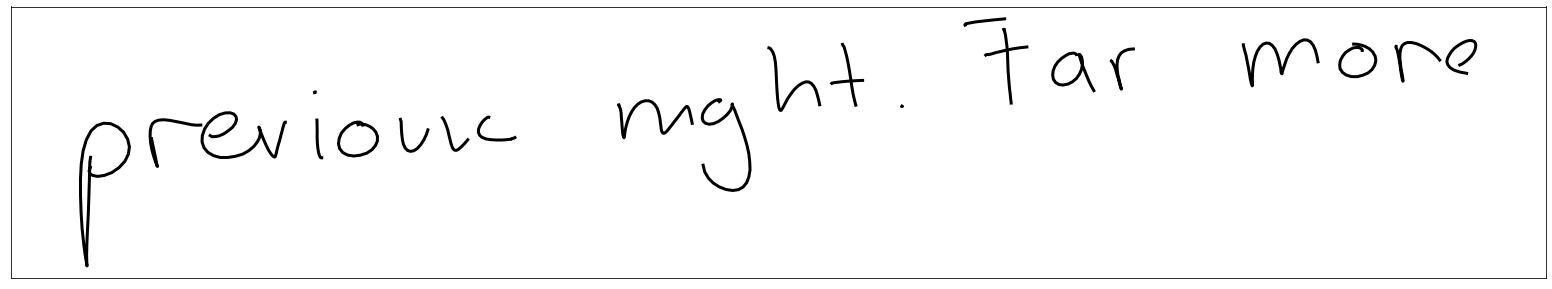

In [63]:
plot_stroke(one_stroke)